# CSF ANALYSIS FOR PPMI data


Created: 2018-08-07    
By: Hirotaka Iwaki

Required data for this analysis:    
* "Current_Biospecimen_Analysis_Results.csv" from PPMI-LONI    
* "01_extract_EVENTDATE.csv" derived from PPMI dataset    
* "02_LatestDiagDemog.csv" derived from PPMI dataset: ([codes](https://github.com/hirotaka-i/PDcohorts/blob/master/PPMI/codes))   
* Genotypings data from LNG: Imputed and filtered (MAF >0.001, Rsq >0.3, and cut per 20K SNPs per file.)
* "PPMI.pca.eigenvec": PCs derived from genotyping data


## Objective/Model
GWAS analysis for CSF $\alpha$-synuclein concentrations.    
A linear model adjusting for sex, age, and CSF hemoglobin >200 with random intercept for individuals.     
After diagnosis, the CSF $\alpha$-synuclein concentrations don't change much. -> no need to think about the effect on slope.    
Patients and healthy controls are analyzed separately and meta-analized if appropriate.

## Data preparation
### CSF file
Extract $\alpha$-synuclein concentrations and CSF hemoglobin levels from "Current_Biospecimen_Analysis_Results.csv" and give the visiting date from "01_extract_EVENTDATE.csv".

In [156]:
%%bash
mkdir -p temp
awk 'BEGIN{FS=",";OFS="\t"}/CSF Alpha-synuclein/{print $1"_"$4,$7}' \
    data/Current_Biospecimen_Analysis_Results.csv | \
    sed 's/"//g' | sort > temp/asyn.txt
awk 'BEGIN{FS=",";OFS="\t"}/CSF Hemoglobin/{print $1"_"$4,$7}' \
    data/Current_Biospecimen_Analysis_Results.csv | \
    sed 's/"//g' | sort > temp/hemo.txt
awk 'BEGIN{FS=",";OFS="\t"}//{print $1"_"$2,$3}' data/01_extract_EVENTDATE.csv | \
    sed 's/"//g' | sort > temp/event_date.txt
join temp/asyn.txt temp/hemo.txt | join - temp/event_date.txt | sed 's/_/ /g' > \
    temp/asyn_hemo.txt # space separated

### Merge the above  file with Demographic file
merge with "02_LatestDiagDemog.csv

In [109]:
%%bash
echo '
library(dplyr)
library(data.table)
t1 = fread("data/02_LatestDiagDemog.csv", header=T)
t2 = fread("temp/asyn_hemo.txt", header=F, , na.strings="N/A") %>% 
    mutate(V1 = as.character(V1)) %>% #  V1(ID) regarded as int
    filter(!is.na(V2) & !is.na(V3)) # delete "N/A" value observation in ANSN and HEMO
names(t2)=c("ID", "EVENT_ID","ASYN", "HEMO", "DATE")
d1 = left_join(t2, t1, by = "ID")
d1 %>% mutate(HEMO_num = as.numeric(HEMO)) %>% filter(is.na(HEMO_num)) %>%
    with(table(HEMO, useNA="always"))
##############################
# The output of above line ###########
# HEMO
#   >20 above below  <NA>
#    28   314  1918     0
# Warning message:
# In evalq(as.numeric(HEMO), <environment>) : NAs introduced by coercion ((<- Warning but OK))
# ((Although, I suspect ">20" is actually "<20", I will eliminate ">20" obs in the following))
###############################
d2 = d1 %>% mutate(HEMO200 = case_when(
    HEMO==">20"~99, # for elimination
    HEMO=="below"~ 0,
    HEMO=="above"~ 1,
    TRUE~ if_else(as.numeric(HEMO)>200, 1, 0))) %>%
    mutate(logASYN = log(ASYN),
           AGE = (as.numeric(as.Date(DATE)) - BIRTHDT)/365.25) %>% 
    filter(HEMO200!=99) %>% # eliminate HEMO = ">20" obs
    mutate(CASE = case_when(
      grepl("PD_YsImg_PPMI", DIAG) ~ 1, 
      grepl("CTR_YsImg_PPMI", DIAG) ~ 0,
      TRUE ~ 99
    )) %>%
    mutate (IID = paste(ID,ID,sep="_")) # for later step to merge with Genotyping data
d2 %>% with(table(CASE), useNA="always")
d3 = d2 %>% filter(CASE!=99) %>% # num_of_obs 3200 -> 2600
    select(IID,ASYN,CASE, FEMALE,AGE,HEMO200) %>%
    arrange(IID)
write.table(d3, "temp/pheno.txt", row.names = F, quote = F, sep = "\t")
print("complete")
' > _pheno.R

In [110]:
%%bash
module load R
Rscript --vanilla _pheno.R

HEMO
  >20 above below  <NA> 
   28   314  1917     0 
CASE
   0    1   99 
 797 1747  663 
[1] "complete"


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
In evalq(as.numeric(HEMO), <environment>) : NAs introduced by coercion
Warning message:
In if_else(as.numeric(HEMO) > 200, 1, 0) : NAs introduced by coercion


### Mege with the PCs file
merge with "PPMI.pca.eigenvec"

In [111]:
%%bash
sort temp/pheno.txt > temp/pheno_sort.txt
cut -f 2- data/PPMI.pca.eigenvec | sort | join -t$'\t' temp/pheno_sort.txt -  > temp/pheno_PC5_temp.txt
grep 'IID' temp/pheno_PC5_temp.txt > temp/pheno_PC5_colnames.txt
grep -v 'IID' temp/pheno_PC5_temp.txt | cat temp/pheno_PC5_colnames.txt - > temp/pheno_PC5.txt

## GLMM analysis

### R code for analysis

In [134]:
%%bash
echo '
args <- commandArgs(trailingOnly = TRUE)
OUTCOME = args[1]
DATASET = args[2]
chrNUM =  args[3]
ITER =  args[4]
FOLDER = args[5]
CASECODE = as.numeric(args[6])

library(data.table);library(dplyr);library(lme4)
# Read pheno.txt and set COV (PC1 and PC2)
cohort=fread("temp/pheno_PC5.txt") # %>% filter(CASE==CASECODE) # Only limiting to cases
COVs = names(cohort)[c(-(1:3),-9, -10, -11)] # eliminate ID, OUTCOME, CASE, PC3-5 from covariates
# Read genotyping data
SNPset = fread(paste("zcat -f ", FOLDER, "/", DATASET, "/", chrNUM, ".", ITER, ".trans.txt.gz", sep=""))
SNPs = names(SNPset)[-(1:2)] # 1 ID, 2 DOSE, SNP name starts from 3
## Merge
cohort_snp = left_join(cohort, SNPset, by = c("IID"="ID"))
write.csv(cohort_snp[,1:20], "temp/_temp.csv")
# Set function for analysis
glmm.listfunc = function(x){
  # Models
  MODEL = paste(OUTCOME, "~", "`", SNPs[x], "`+", paste(COVs, collapse="+"), "+(1|IID)", sep = "")
  testLmer = try(lmer(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testLmer)[1]=="try-error"){
    sumstat=rep("DROP",6)
  }else{
    temp = summary(testLmer)
    temp1 = temp$coefficients
    if(grep(SNPs[x], rownames(temp1)) %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=rep(NA,6)
    }else{
      RES = temp1[2,] # The first row is intercept
      PV_APPROX = 2 * pnorm(abs(RES[3]), lower.tail=F) # df is enough large for approximation
      OBS_N = paste(length(temp$residuals), "_", temp$ngrps, sep="")
      sumstat <- c(SNPs[x], OBS_N, RES[3], RES[1], RES[2], PV_APPROX)
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), glmm.listfunc)
temp2 = do.call(rbind, temp)
attributes(temp2)$dimnames[[2]]=c("SNP", "OBS_N", "Tvalue", "Beta", "SE", "Pv_approx")
head(temp2)
NEWDIR = paste("/data/LNG/Hirotaka/ASYN/", OUTCOME, "/", chrNUM, sep = "")
dir.create(NEWDIR, recursive = T, showWarnings = F)
write.table(temp2, paste(NEWDIR, "/", DATASET, CASECODE, ".", ITER, ".txt", sep=""), row.names = F, quote = F, sep = "\t")
print("complete")
' > _analysis.R

testrun

In [135]:
%%bash
module load R
Rscript --vanilla _analysis.R ASYN PPMI chr12 11  /data/LNG/Hirotaka/progGWAS/SNPfilter/maf001rsq3_20Kcut 1

     SNP                OBS_N      Tvalue               Beta               
[1,] "12:133435735_C_T" "2211_499" "0.466716837974515"  "299.734360406519" 
[2,] "12:133435793_C_T" "2211_499" "-0.647698843465301" "-555.989155686094"
[3,] "12:133435861_C_T" "2211_499" "1.14089221530962"   "108.715849628715" 
[4,] "12:133436127_A_G" "2211_499" "1.02662554369804"   "239.823438043981" 
[5,] "12:133436499_C_T" "2211_499" "0.0820380234755894" "5.38176923817528" 
[6,] "12:133437240_G_A" "2211_499" "-0.668619623065455" "-30.8986974886041"
     SE                 Pv_approx          
[1,] "642.218870241158" "0.640702481297696"
[2,] "858.406898970911" "0.517179752422419"
[3,] "95.2902019751371" "0.253914779350272"
[4,] "233.60361479036"  "0.304596821289577"
[5,] "65.6009129690532" "0.934616476986448"
[6,] "46.212669240758"  "0.503738151738932"
[1] "complete"


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
Warning messages:
1: Some predictor variables are on very different scales: consider rescaling 
2: Some predictor variables are on very different scales: consider rescaling 
3: Some predictor variables are on very different scales: consider rescaling 
4: Some predictor variables are on very different scales: consider rescaling 
5: Some predictor variables are on very different scales: consider rescaling 


### Create .swarm file and submit
"swirm" is an NIH-wrapper for job array    
create .swirm files and then submit these jobs

In [150]:
%%bash
FOLDER=/data/LNG/Hirotaka/progGWAS/SNPfilter/maf001rsq3_20Kcut
rm _analysis*.swarm 
for j in $(ls $FOLDER/PPMI);do
    chrNUM=$(echo $j | cut -d '.' -f 1)
    ITER=$(echo $j | cut -d '.' -f 2)
    for CASECODE in 0 1;do
        if [ $CASECODE == 1 ]; then
            echo "Rscript --vanilla _analysis.R ASYN PPMI $chrNUM $ITER  $FOLDER $CASECODE" >> _analysisCASE.swarm
        else
            echo "Rscript --vanilla _analysis.R ASYN PPMI $chrNUM $ITER  $FOLDER $CASECODE" >> _analysisCTRL.swarm
        fi
    done;
done;

In [153]:
%%bash
rm -rf swarm_analysis
swarm -f  _analysisCASE.swarm --time=3:00:00 -g 3 -p 2 -b 8 --logdir ./swarm_CASE --module R --devel
swarm -f  _analysisCTRL.swarm --time=3:00:00 -g 3 -p 2 -b 8 --logdir ./swarm_CTRL --module R --devel

Loading modules R
207 commands run in 13 subjobs, each command requiring 3 gb and 1 thread, packing 2 processes per subjob, running 8 processes serially per subjob
sbatch --array=0-12 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=6144 --partition=norm --time=24:00:00 /spin1/swarm/iwakih2/S21ST0WsVw/swarm.batch
Loading modules R
207 commands run in 13 subjobs, each command requiring 3 gb and 1 thread, packing 2 processes per subjob, running 8 processes serially per subjob
sbatch --array=0-12 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=6144 --partition=norm --time=24:00:00 /spin1/swarm/iwakih2/iDRkch3h5K/swarm.batch


In [155]:
6811355
6811357

6811357

## meta_analysis

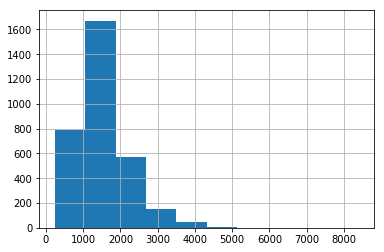

In [179]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
t1 = pd.read_table("temp/asyn_hemo.txt", sep=" ", 
                   names=("ID", "EVENT_ID", "ASYN","HEMO", "DATE"))
t1.ASYN.hist()

In [180]:
t1.dtypes

ID            int64
EVENT_ID     object
ASYN        float64
HEMO         object
DATE         object
dtype: object

In [181]:
def cut_hemo200(x):
    if x == "above":
        return 1
    elif x == "below":
        return 0
    elif x == ">20":
        return 99
    else:
        try:
            float(x)
            return 1
        except ValueError:
            return 999
t1['HEMO200'] = t1['HEMO'].apply(cut_hemo200)
if len(t1[t1['HEMO200']>998]) == 0:
    print("OK")

OK


In [183]:
t1['ASYN_num'] = pd.to_numeric(t1['ASYN'], errors="coerce")
t1['HEMO_num'] = pd.to_numeric(t1['HEMO'], errors="coerce")
t1.head()

,ID,EVENT_ID,ASYN,HEMO,DATE,HEMO200,ASYN_num,HEMO_num
0,10874,BL,1778.3,148.0,2014-09-01,1,1778.3,148.0
1,10874,V02,2459.3,below,2015-03-01,0,2459.3,NaN
2,10874,V04,1729.8,below,2015-08-01,0,1729.8,NaN
3,12224,BL,1029.7,below,2013-10-01,0,1029.7,NaN
4,12224,V02,891.2,below,2014-05-01,0,891.2,NaN
